In [36]:
import gensim
import nltk
import numpy
import tensorflow
import torch
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.models import *
from keras.layers import *
from keras.callbacks import *
import random
import matplotlib.pyplot as plt 
from keras.models import Model
from keras.layers import Dense, Input, LSTM, GRU, Conv1D, MaxPooling1D, Concatenate  ,SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.models import Sequential 
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def split_train_val(x,y,ratio) :
    in_out = []
    
    p_xy = [] 
    n_xy=[]
    
    for i in range( len(x) ) :
        if y[i]== 0 :
            n_xy.append( [x[i],y[i]] )
        else :
            p_xy.append( [ x[i] , y[i] ] )
    
    
    print("debugging meassage -   negative ",len(n_xy)  , " postivie ",len(p_xy))
    
  
    a=random.shuffle( p_xy )
    b=random.shuffle( n_xy )
    print("debugging message  types ", type(a), type(b))
    
    x_val = []
    y_val = []
    x_train = []
    y_train = []
    
    for i in range( len(n_xy )) :
        if i < int(len(n_xy)*ratio) :
            x_train.append( n_xy[i][0] )
            y_train.append( n_xy[i][1] )
        else :
            x_val.append( n_xy[i][0] )
            y_val.append( n_xy[i][1] )
    
    for i in range( len(p_xy) ) :
        if i < int( len(p_xy) * ratio ) :
            x_train.append( p_xy[i][0] )
            y_train.append( p_xy[i][1] )
        else :
            x_val.append( p_xy[i][0] )
            y_val.append( p_xy[i][1] )
    
    
    return [x_train,y_train,x_val,y_val]

In [38]:
def  visualize( x , y ) :
    
    t=150
    d=20
    
    frq_n = numpy.zeros( [t] ) 
    frq_p = numpy.zeros( [t] )
    frq_t = numpy.zeros( [t] )
    
    
    
    length_list=[]
    lens=d
    
    while(lens<=d*t) :
        length_list.append( lens )
        lens = lens + d
    n_p=0
    n_n=0
    print(len(length_list))
    for i in range( len(x) ) :
        length = len( x[i] )
        index = int(length/d)
        if y[i]== 0  :
            n_n=n_n+1
            frq_n[index] = frq_n[index]+1
        else :
            n_p=n_p+1
            frq_p[index] = frq_p[index]+1
            
    frq_t = frq_p + frq_n
         
    sum_n=0
    sum_p=0
    print("positive sample ",n_p," negative sample ",n_n)
    for i in range(t) :
        sum_n = sum_n + frq_n[i]
        sum_p = sum_p + frq_p[i]
        print(  i,length_list[i]  , sum_n/n_n , sum_p/n_p ,( sum_n + sum_p )/(n_n+n_p) )
    
    plt.plot( length_list , frq_p , color= 'red' )
    plt.plot( length_list , frq_n , color = 'green' )
    plt.plot( length_list , frq_t , color = 'blue' )
    
    plt.show()
        
    return [ frq_n , frq_p , frq_t ]

loading pretrained word2vec  ' trained by negative subsampling '

In [39]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

getting words for which embedding is present

In [40]:
vocab_word2vec = word2vec.wv.vocab.keys()

/Users/naman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [41]:
from loader import stanford_train , stanford_test
print("details about training and validation sets combined")
[x_train_val,y_train_val,c] = stanford_train()
print("details on test set")
[x_test,y_test,c] =  stanford_test()

details about training and validation sets combined
number of negative reviews  12500
positive review s 12500
details on test set
number of negative reviews  12500
positive review s 12500


In [42]:
all_data = x_train_val + x_test

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(all_data))

In [44]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'be': 26,
 'one': 27,
 'he': 28,
 'all': 29,
 'at': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'so': 34,
 'who': 35,
 'from': 36,
 'like': 37,
 'or': 38,
 'just': 39,
 'her': 40,
 'out': 41,
 'about': 42,
 'if': 43,
 "it's": 44,
 'has': 45,
 'there': 46,
 'some': 47,
 'what': 48,
 'good': 49,
 'when': 50,
 'more': 51,
 'very': 52,
 'up': 53,
 'no': 54,
 'time': 55,
 'my': 56,
 'even': 57,
 'would': 58,
 'she': 59,
 'which': 60,
 'only': 61,
 'really': 62,
 'see': 63,
 'story': 64,
 'their': 65,
 'had': 66,
 'can': 67,
 'me': 68,
 'well': 69,
 'were': 70,
 'than': 71,
 'much': 72,
 'we': 73,
 'bad': 74,
 'been': 75,
 'get': 76,
 'do': 77,
 'great': 78,
 'other': 79,
 'will': 80,
 'also': 81,
 'into': 82,
 'p

In [45]:
size_of_vocabulary_dataset=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary_dataset)

124253


In [46]:
embedding_matrix = numpy.zeros(( size_of_vocabulary_dataset , 300))

In [47]:
for word, i in tokenizer.word_index.items():
    #print(i,word)
    if word in vocab_word2vec :
        embedding_matrix[i] =  word2vec[word]
        

pre-pairing dataset for training , validation and testing set

In [48]:
[x_train,y_train,x_val,y_val] = split_train_val( x_train_val , y_train_val , 0.7 )

debugging meassage -   negative  12500  postivie  12500
debugging message  types  <class 'NoneType'> <class 'NoneType'>


In [49]:
x_train_sq = tokenizer.texts_to_sequences( x_train )
x_val_sq = tokenizer.texts_to_sequences( x_val )
x_test_sq = tokenizer.texts_to_sequences( x_test )

In [50]:
all_train_test_val = []
for i in range( len(x_train_sq) ) :
    all_train_test_val.append( len(x_train_sq[i]) )
for i in range( len(x_val_sq) ) :
    all_train_test_val.append( len(x_val_sq[i]) )
for i in range( len(x_test_sq) ) :
    all_train_test_val.append( len(x_test_sq[i]) )
maximum = max(all_train_test_val)


In [51]:
maximum

2493

150
positive sample  8750  negative sample  8750
0 20 0.0008 0.0005714285714285715 0.0006857142857142857
1 40 0.005714285714285714 0.007542857142857143 0.006628571428571429
2 60 0.03577142857142857 0.046285714285714284 0.04102857142857143
3 80 0.06754285714285714 0.0888 0.07817142857142857
4 100 0.10274285714285715 0.12708571428571427 0.11491428571428572
5 120 0.17177142857142857 0.20125714285714286 0.18651428571428572
6 140 0.3144 0.32994285714285715 0.32217142857142855
7 160 0.4268571428571429 0.43074285714285715 0.4288
8 180 0.5086857142857143 0.5107428571428572 0.5097142857142857
9 200 0.5802285714285714 0.5723428571428572 0.5762857142857143
10 220 0.6332571428571429 0.62 0.6266285714285714
11 240 0.6746285714285715 0.6628571428571428 0.6687428571428572
12 260 0.7125714285714285 0.7011428571428572 0.7068571428571429
13 280 0.7457142857142857 0.7305142857142857 0.7381142857142857
14 300 0.7723428571428571 0.7566857142857143 0.7645142857142857
15 320 0.7955428571428571 0.780457142857

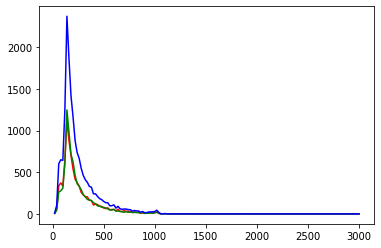

In [52]:
[frq_train_n,frq_train_p,frq_train_t] = visualize(x_train_sq, y_train )

150
positive sample  3750  negative sample  3750
0 20 0.0005333333333333334 0.0 0.0002666666666666667
1 40 0.005066666666666666 0.0088 0.006933333333333333
2 60 0.028533333333333334 0.044533333333333334 0.036533333333333334
3 80 0.06213333333333333 0.08373333333333334 0.07293333333333334
4 100 0.09706666666666666 0.1192 0.10813333333333333
5 120 0.1736 0.1952 0.1844
6 140 0.31653333333333333 0.3224 0.3194666666666667
7 160 0.41786666666666666 0.42533333333333334 0.4216
8 180 0.5029333333333333 0.5050666666666667 0.504
9 200 0.5706666666666667 0.5594666666666667 0.5650666666666667
10 220 0.6245333333333334 0.6146666666666667 0.6196
11 240 0.6704 0.6578666666666667 0.6641333333333334
12 260 0.7096 0.6949333333333333 0.7022666666666667
13 280 0.7442666666666666 0.7261333333333333 0.7352
14 300 0.7706666666666667 0.7528 0.7617333333333334
15 320 0.7954666666666667 0.7805333333333333 0.788
16 340 0.8202666666666667 0.7986666666666666 0.8094666666666667
17 360 0.8421333333333333 0.8173333333

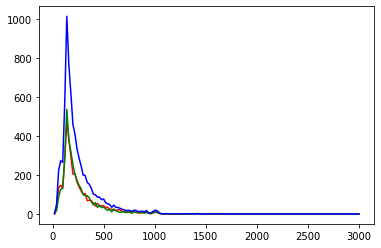

In [53]:
[frq_train_n,frq_train_p,frq_train_t] = visualize(x_val_sq, y_val )


150
positive sample  12500  negative sample  12500
0 20 0.00048 0.00064 0.00056
1 40 0.0072 0.00776 0.00748
2 60 0.0404 0.04496 0.04268
3 80 0.07296 0.0904 0.08168
4 100 0.10912 0.12848 0.1188
5 120 0.18392 0.20664 0.19528
6 140 0.3168 0.34064 0.32872
7 160 0.4236 0.44136 0.43248
8 180 0.51 0.52416 0.51708
9 200 0.57736 0.58848 0.58292
10 220 0.63272 0.64296 0.63784
11 240 0.68016 0.68536 0.68276
12 260 0.71456 0.72056 0.71756
13 280 0.74576 0.74752 0.74664
14 300 0.77528 0.7744 0.77484
15 320 0.80048 0.79848 0.79948
16 340 0.82152 0.81904 0.82028
17 360 0.8396 0.83584 0.83772
18 380 0.85784 0.85104 0.85444
19 400 0.87336 0.86512 0.86924
20 420 0.88736 0.8768 0.88208
21 440 0.89976 0.88792 0.89384
22 460 0.90984 0.898 0.90392
23 480 0.91968 0.90712 0.9134
24 500 0.926 0.91528 0.92064
25 520 0.93208 0.92312 0.9276
26 540 0.93864 0.93096 0.9348
27 560 0.94496 0.93712 0.94104
28 580 0.95024 0.94376 0.947
29 600 0.9548 0.94888 0.95184
30 620 0.95848 0.95408 0.95628
31 640 0.9624 0.95816 0.

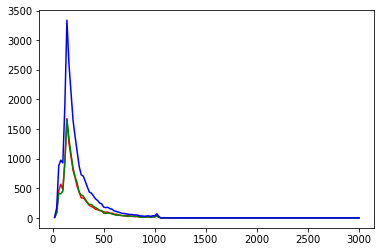

In [54]:
[frq_train_n,frq_train_p,frq_train_t] = visualize(x_test_sq, y_test )

In [55]:
for i in range(len(y_train)) :
    y_train[i] = float(y_train[i])
for i in range(len(y_val)) :
    y_val[i] = float(y_val[i])

In [56]:
threshold = 1000
x_train_sq_pd = pad_sequences( x_train_sq , maxlen = threshold )
x_val_sq_pd = pad_sequences( x_val_sq , maxlen = threshold )
x_test_sq_pd = pad_sequences( x_test_sq , maxlen = threshold)

# shallow vanila RNN

In [22]:
model = Sequential()
model.add(Embedding(size_of_vocabulary_dataset,300,weights=[embedding_matrix],input_length= threshold ,trainable=False)) 
model.add( SimpleRNN ( 64 , activation = 'sigmoid' ) )
model.add( Dense( 1 , activation = 'sigmoid' ) )

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'] )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model_shallow_VRNN.h', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 300)         37275900  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                23360     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 37,299,325
Trainable params: 23,425
Non-trainable params: 37,275,900
_________________________________________________________________
None


In [ ]:
history = model.fit(numpy.array(x_train_sq_pd),numpy.array(y_train),batch_size=128,epochs=10,validation_data=(numpy.array(x_val_sq_pd),numpy.array(y_val)),verbose=1,callbacks=[es,mc])

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 140s 8ms/step - loss: 0.6769 - acc: 0.5663 - val_loss: 0.6606 - val_acc: 0.6035

Epoch 00001: val_acc improved from -inf to 0.60347, saving model to best_model_shallow_VRNN.h
Epoch 2/10
17408/17500 [============================>.] - ETA: 0s - loss: 0.6477 - acc: 0.6212

In [ ]:
model = load_model('best_model_shallow_VRNN.h')

#evaluation 
_,train_acc = model.evaluate(x_train_sq_pd,y_train, batch_size=128)
_,val_acc = model.evaluate( x_val_sq_pd , y_val , batch_size = 128 )
_,test_acc = model.evaluate( x_test_sq_pd , y_test , batch_size=128 )
print("train acc ",test_acc)
print("val acc ",val_acc)
print("test acc ",test_acc)

# DEEP VANILA RNN

In [ ]:
model = Sequential()
model.add(Embedding(size_of_vocabulary_dataset,300,weights=[embedding_matrix],input_length= threshold ,trainable=False)) 
model.add( SimpleRNN ( 64 , activation = 'tanh' , retur_sequences = True ) )
model.add( SimpleRNN(64,activation = 'tanh') , return_sequences = False )

model.add( Dense(32,activation = 'sigmoid' ) )
model.add( Dense( 1 , activation = 'sigmoid' ) )

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'] )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model_deep_VRNN.h', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())




In [ ]:
history = model.fit(numpy.array(x_train_sq_pd),numpy.array(y_train),batch_size=128,epochs=10,validation_data=(numpy.array(x_val_sq_pd),numpy.array(y_val)),verbose=1,callbacks=[es,mc])

In [ ]:
model = load_model('best_model_deep_VRNN.h')

#evaluation 
_,train_acc = model.evaluate(x_train_sq_pd,y_train, batch_size=128)
_,val_acc = model.evaluate( x_val_sq_pd , y_val , batch_size = 128 )
_,test_acc = model.evaluate( x_test_sq_pd , y_test , batch_size=128 )
print("train acc ",train_acc)
print("val acc ",val_acc)
print("test acc ",test_acc)

# shallow GRU 

In [164]:
model = Sequential()
model.add(Embedding(size_of_vocabulary_dataset,300,weights=[embedding_matrix],input_length= threshold ,trainable=False)) 

model.add(GRU(64,return_sequences=False,dropout=0.2))
#model.add(GlobalMaxPooling1D())

#model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='softmax')) 



model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'] )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model_shallow_GRU.h', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1000, 300)         37275900  
_________________________________________________________________
gru_10 (GRU)                 (None, 64)                70080     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 37,346,045
Trainable params: 70,145
Non-trainable params: 37,275,900
_________________________________________________________________
None


In [166]:
history = model.fit(numpy.array(x_train_sq_pd),numpy.array(y_train),batch_size=128,epochs=10,validation_data=(numpy.array(x_val_sq_pd),numpy.array(y_val)),verbose=1,callbacks=[es,mc])

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 317s 18ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to best_model_GRU_sh.h
Epoch 2/10
17500/17500 [==============================] - 321s 18ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/10
17500/17500 [==============================] - 343s 20ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/10
17500/17500 [==============================] - 319s 18ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.50000
Epoch 00004: early stopping


In [34]:
model = load_model('best_model_shallow_GRU.h')

#evaluation 
_,train_acc = model.evaluate(x_train_sq_pd,y_train, batch_size=128)
_,val_acc = model.evaluate( x_val_sq_pd , y_val , batch_size = 128 )
_,test_acc = model.evaluate( x_test_sq_pd , y_test , batch_size=128 )
print("train acc ",train_acc)
print("val acc ",val_acc)
print("test acc ",test_acc)

25000/25000 [==============================] - 145s 6ms/step
train acc  0.7563199996948242
val acc  0.7544000148773193
test acc  0.7563199996948242


In [35]:
train_acc

0.7574856877326965

# deep GRU

In [59]:
model = Sequential()
model.add(Embedding(size_of_vocabulary_dataset,300,weights=[embedding_matrix],input_length= threshold ,trainable=False)) 

model.add(GRU(64,return_sequences=True,dropout=0.2))
model.add ( GRU(64,return_sequences=False, dropout=0.2) )

model.add(Dense(32,activation='softmax')) 
model.add(Dense(1,activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'] )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model_deep_GRU.h', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

print(model.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 300)         37275900  
_________________________________________________________________
gru_1 (GRU)                  (None, 1000, 64)          70080     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 37,372,861
Trainable params: 96,961
Non-trainable params: 37,275,900
_________________________________________________________________
None


In [60]:
history = model.fit(numpy.array(x_train_sq_pd),numpy.array(y_train),batch_size=128,epochs=10,validation_data=(numpy.array(x_val_sq_pd),numpy.array(y_val)),verbose=1,callbacks=[es,mc])

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 501s 29ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to best_model_deep_GRU.h
Epoch 2/10
17500/17500 [==============================] - 487s 28ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/10
 2944/17500 [====>.........................] - ETA: 6:21 - loss: 7.6458 - acc: 0.5014

KeyboardInterrupt: 

In [ ]:
model = load_model('best_model_deep_GRU.h')

#evaluation 
_,train_acc = model.evaluate(x_train_sq_pd,y_train, batch_size=128)
_,val_acc = model.evaluate( x_val_sq_pd , y_val , batch_size = 128 )
_,test_acc = model.evaluate( x_test_sq_pd , y_test , batch_size=128 )
print("train acc ",train_acc)
print("val acc ",val_acc)
print("test acc ",test_acc)

18944/25000 [=====================>........] - ETA: 50s

# shallow LSTM

In [27]:
model = Sequential()
model.add(Embedding(size_of_vocabulary_dataset,300,weights=[embedding_matrix],input_length= threshold ,trainable=False)) 

model.add ( LSTM(64,return_sequences=False) )

model.add(Dense(32,activation='sigmoid')) 
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'] )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model_shallow_LSTM.h', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 300)         37275900  
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 37,371,453
Trainable params: 95,553
Non-trainable params: 37,275,900
_________________________________________________________________
None


In [28]:
history = model.fit(numpy.array(x_train_sq_pd),numpy.array(y_train),batch_size=128,epochs=10,validation_data=(numpy.array(x_val_sq_pd),numpy.array(y_val)),verbose=1,callbacks=[es,mc])

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 387s 22ms/step - loss: 0.5618 - acc: 0.7078 - val_loss: 0.4348 - val_acc: 0.8109

Epoch 00001: val_acc improved from -inf to 0.81093, saving model to best_model_shallow_LSTM.h
Epoch 2/10
17500/17500 [==============================] - 373s 21ms/step - loss: 0.4232 - acc: 0.8152 - val_loss: 0.3927 - val_acc: 0.8369

Epoch 00002: val_acc improved from 0.81093 to 0.83693, saving model to best_model_shallow_LSTM.h
Epoch 3/10
17500/17500 [==============================] - 344s 20ms/step - loss: 0.4570 - acc: 0.7981 - val_loss: 0.4109 - val_acc: 0.8271

Epoch 00003: val_acc did not improve from 0.83693
Epoch 4/10
17500/17500 [==============================] - 339s 19ms/step - loss: 0.3831 - acc: 0.8395 - val_loss: 0.7514 - val_acc: 0.7295

Epoch 00004: val_acc did not improve from 0.83693
Epoch 5/10
17500/17500 [==============================] - 338s 19ms/step - loss: 0.4324 - acc: 0.814

KeyboardInterrupt: 

In [29]:
model = load_model('best_model_shallow_LSTM.h')

#evaluation 
_,train_acc = model.evaluate(x_train_sq_pd,y_train, batch_size=128)
_,val_acc = model.evaluate( x_val_sq_pd , y_val , batch_size = 128 )
_,test_acc = model.evaluate( x_test_sq_pd , y_test , batch_size=128 )
print("train acc ",train_acc)
print("val acc ",val_acc)
print("test acc ",test_acc)

25000/25000 [==============================] - 143s 6ms/step
train acc  0.8556399941444397
val acc  0.8565333485603333
test acc  0.8556399941444397


# deep LSTM

In [57]:
model = Sequential()
model.add(Embedding(size_of_vocabulary_dataset,300,weights=[embedding_matrix],input_length= threshold ,trainable=False)) 

model.add ( LSTM(64,return_sequences=True) )
model.add( LSTM(64,return_sequences=False) )

model.add(Dense(32,activation='sigmoid')) 
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'] )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model_deep_LSTM.h', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 300)         37275900  
_________________________________________________________________
lstm_6 (LSTM)                (None, 1000, 64)          93440     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 37,404,477
Trainable params: 128,577
Non-trainable params: 37,275,900
_________________________________________________________________
None


In [58]:
history = model.fit(numpy.array(x_train_sq_pd),numpy.array(y_train),batch_size=128,epochs=10,validation_data=(numpy.array(x_val_sq_pd),numpy.array(y_val)),verbose=1,callbacks=[es,mc])

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
  768/17500 [>.............................] - ETA: 11:41 - loss: 0.7200 - acc: 0.5260

KeyboardInterrupt: 

In [ ]:
model = load_model('best_model_deep_LSTM.h')

#evaluation 
_,train_acc = model.evaluate(x_train_sq_pd,y_train, batch_size=128)
_,val_acc = model.evaluate( x_val_sq_pd , y_val , batch_size = 128 )
_,test_acc = model.evaluate( x_test_sq_pd , y_test , batch_size=128 )
print("train acc ",train_acc)
print("val acc ",val_acc)
print("test acc ",test_acc)